In [1]:
import wotplot
from matplotlib import pyplot

# 1. The simple example from the README

## 1.1. Define a small dataset

In [2]:
s1 = "AGCAGGAGATAAACCTGT"
s2 = "AGCAGGTTATCTACCTGT"
k = 3

## 1.2. Create a dot plot matrix

In [3]:
m = wotplot.make(s1, s2, k)

## 1.3. Inspect the dot plot matrix

In [4]:
type(m)

wotplot._matrix.DotPlotMatrix

In [5]:
m

DotPlotMatrix(mat=<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>, s1="AGCAGGAGATAAACCTGT", s2="AGCAGGTTATCTACCTGT", k=3, yorder="BT", binary=True)

In [6]:
print(str(m))

DotPlotMatrix(k = 3, binary, bottom → top): 16x16


The `DotPlotMatrix` object we just created, `m`, contains some extra information about the way it was created (e.g. the value of `k` we used). But the most interesting part of it is the actual matrix describing the dot plot! This matrix is stored in the `mat` attribute.

In [7]:
m.mat

<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>

### 1.3.1. Why is this matrix 16x16? Shouldn't it be 18x18?

You might have noticed that `s1` and `s2` are 18 nucleotides long. Why, then, does `m.mat` only have 16 rows and 16 columns?

The reason for this is that, in an arbitrary string $s$, the number of $k$-mers is $|s| - k + 1$. For `s1` and `s2`, $|s| - k + 1 = 18 - 3 + 1 = 16$.

A way of thinking about this: the last 3-mer in `s1` is `TGT`, starting at the 16th position in `s1` (using 1-indexing). There are always going to be $k - 1$ characters left over (for `s1`, these are the final `G` and `T`) where no $k$-mers can begin.

### 1.3.2. What's the deal with sparse matrices?

Most dot plot matrices are _sparse_: that is, most of their entries are zeroes. We exploit this by storing our matrices as [sparse matrices](https://en.wikipedia.org/wiki/Sparse_matrix)—these objects drastically reduce the memory requirements when our input sequences are long (more than a few thousand nucleotides).

It's possible to convert our sparse matrix back to an equivalent "dense" matrix; this can make these matrices easier to work with, although it might require a large amount of memory if your input sequences were long. Here's an example of creating a dense copy of `m.mat`:

In [8]:
m.mat.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 1.3.3. Sidenote about the matrix type
Depending on the version of SciPy you have installed, this matrix will have the type [`scipy.sparse.coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) (SciPy < 1.8) or  [`scipy.sparse.coo_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html) (SciPy ≥ 1.8). There shouldn't be much of a difference, at least for our use of these objects.

## 1.4. Visualize the dot plot matrix

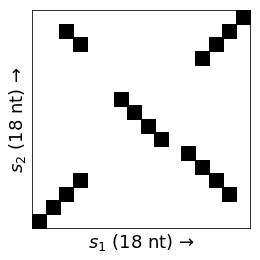

In [9]:
fig, ax = wotplot.viz_binary(m)
# Save the visualization to a file
fig.savefig("example_dotplot.png", bbox_inches="tight")

# 2. An example of tiling multiple dot plots

... and messing around with a few of matplotlib's many options.

Notice how we provide an argument to the `ax` parameter of `wotplot.viz_binary()` -- this way, we can create these `Axes` objects in advance (when we call `pyplot.subplots`). By controlling the figure's layout from the start, we have a lot of control over what it'll end up looking like.

Text(0.5, 1.0, 'Top-to-bottom')

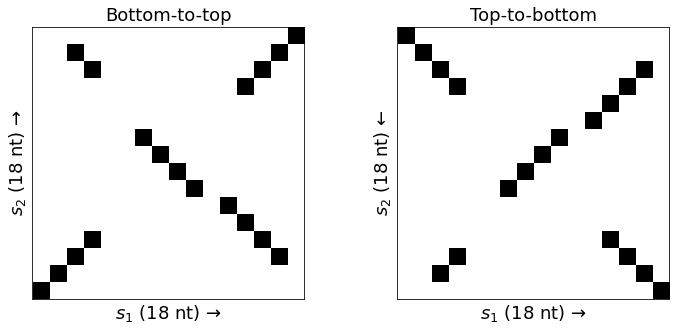

In [10]:
m_flipped = wotplot.make(s1, s2, k, yorder="TB")

fig, (axLeft, axRight) = pyplot.subplots(1, 2)
fig.set_size_inches(12,5)

wotplot.viz_binary(m, ax=axLeft)
wotplot.viz_binary(m_flipped, ax=axRight)

axLeft.set_title('Bottom-to-top', fontsize=18)
axRight.set_title('Top-to-bottom', fontsize=18)